# Loan Prediction Model

This notebook provides an end-to-end solution for the loan approval prediction problem. The goal is to predict whether a loan application will be approved using advanced machine learning techniques. The steps involve data exploration, preprocessing, feature engineering, model training, hyperparameter tuning, ensembling, and evaluation to understand the factors affecting loan approval and determine the best predictive model.

## Table of Contents

1. Why These Choices?
2. Import Libraries
3. Load Dataset
4. Exploratory Data Analysis (EDA)
5. Data Preprocessing
6. Feature Engineering
7. Handling Class Imbalance
8. Model Training and Evaluation
    - Gradient Boosting
    - XGBoost
    - CatBoost
    - LightGBM
    - Ensemble Voting Classifier
9. Hyperparameter Tuning
10. Feature Importance
11. Model Explainability
12. Predictions on Test Data
13. Submission
14. Additional Improvements

## Why These Choices?

### Data Preprocessing
Handling missing values, encoding categorical variables, and feature scaling are essential to ensure that machine learning models can learn effectively from the data.

### Model Selection
We use a variety of robust models such as Gradient Boosting, XGBoost, CatBoost, and LightGBM. These models are effective in handling structured/tabular data and capturing complex patterns.

### Addressing Class Imbalance
Loan approval datasets often have imbalanced classes. Techniques like SMOTE or adjusting class weights help models learn minority class patterns better.

### Hyperparameter Tuning
Optimizing model parameters can significantly enhance performance, ensuring models are well-fitted to the data.

### Model Ensembling
Combining multiple models can leverage their strengths and mitigate individual weaknesses, leading to better overall performance.

### Evaluation Metrics
Using validation accuracy, precision, recall, F1-score, and ROC-AUC provides a comprehensive understanding of model performance, especially on imbalanced data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, confusion_matrix
)
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Load Dataset

We have three datasets:
- **Train dataset (`train.csv`)**: Contains historical data with features and labels (`loan_status`). Used to train machine learning models.
- **Test dataset (`test.csv`)**: Contains similar features as the train dataset but without labels. Used to make predictions.
- **Submission dataset (`sample_submission.csv`)**: Template for submission, ensuring predictions are formatted according to competition requirements.

In [2]:
# Load datasets
train_path = '/kaggle/input/playground-series-s4e10/train.csv'
test_path = '/kaggle/input/playground-series-s4e10/test.csv'
submission_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'

data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

print("Train Data Shape:", data.shape)
print("Test Data Shape:", test_data.shape)
print("Sample Submission Shape:", submission.shape)

Train Data Shape: (58645, 13)
Test Data Shape: (39098, 12)
Sample Submission Shape: (39098, 2)


## Exploratory Data Analysis (EDA)

### Overview of the Data

In [3]:
data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


### Target Variable Distribution

Understanding the distribution of the target variable helps in identifying class imbalance.

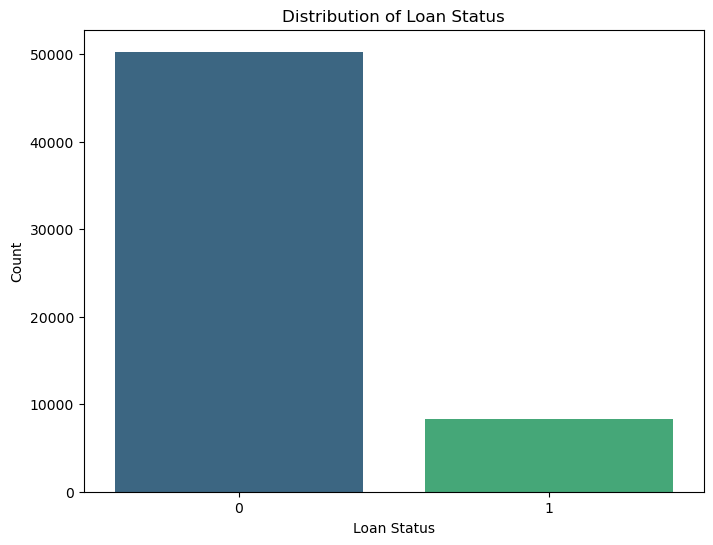

   Count  Percentage
0  50295   85.761787
1   8350   14.238213


In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=data, palette='viridis')
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Percentage distribution
loan_status_counts = data['loan_status'].value_counts()
loan_status_percent = data['loan_status'].value_counts(normalize=True) * 100
df_loan_status = pd.DataFrame({
    'Count': loan_status_counts,
    'Percentage': loan_status_percent
})
print(df_loan_status)

### Correlation Heatmap

Visualizing feature correlations to identify multicollinearity and feature importance.

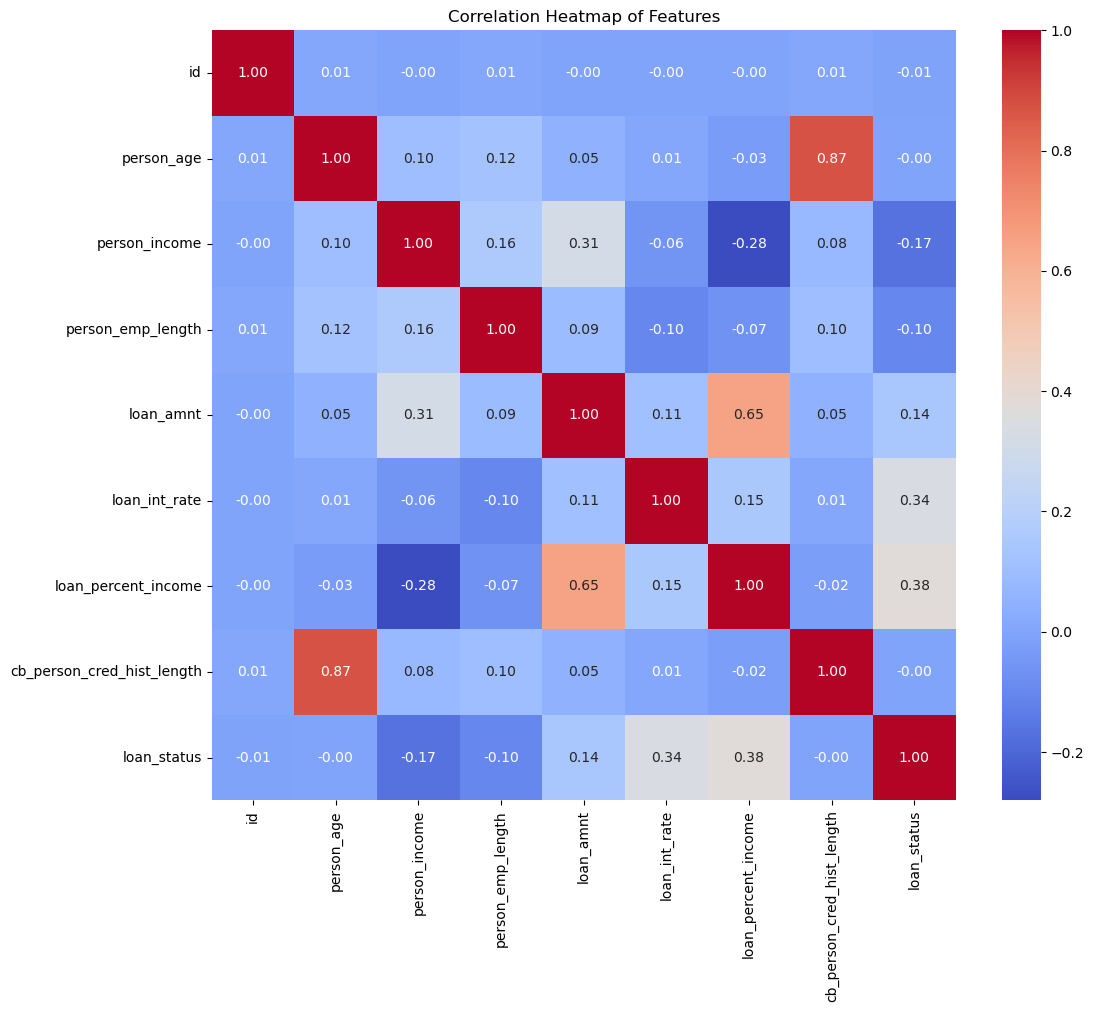

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

### Univariate Analysis

Exploring distributions of numerical and categorical features.

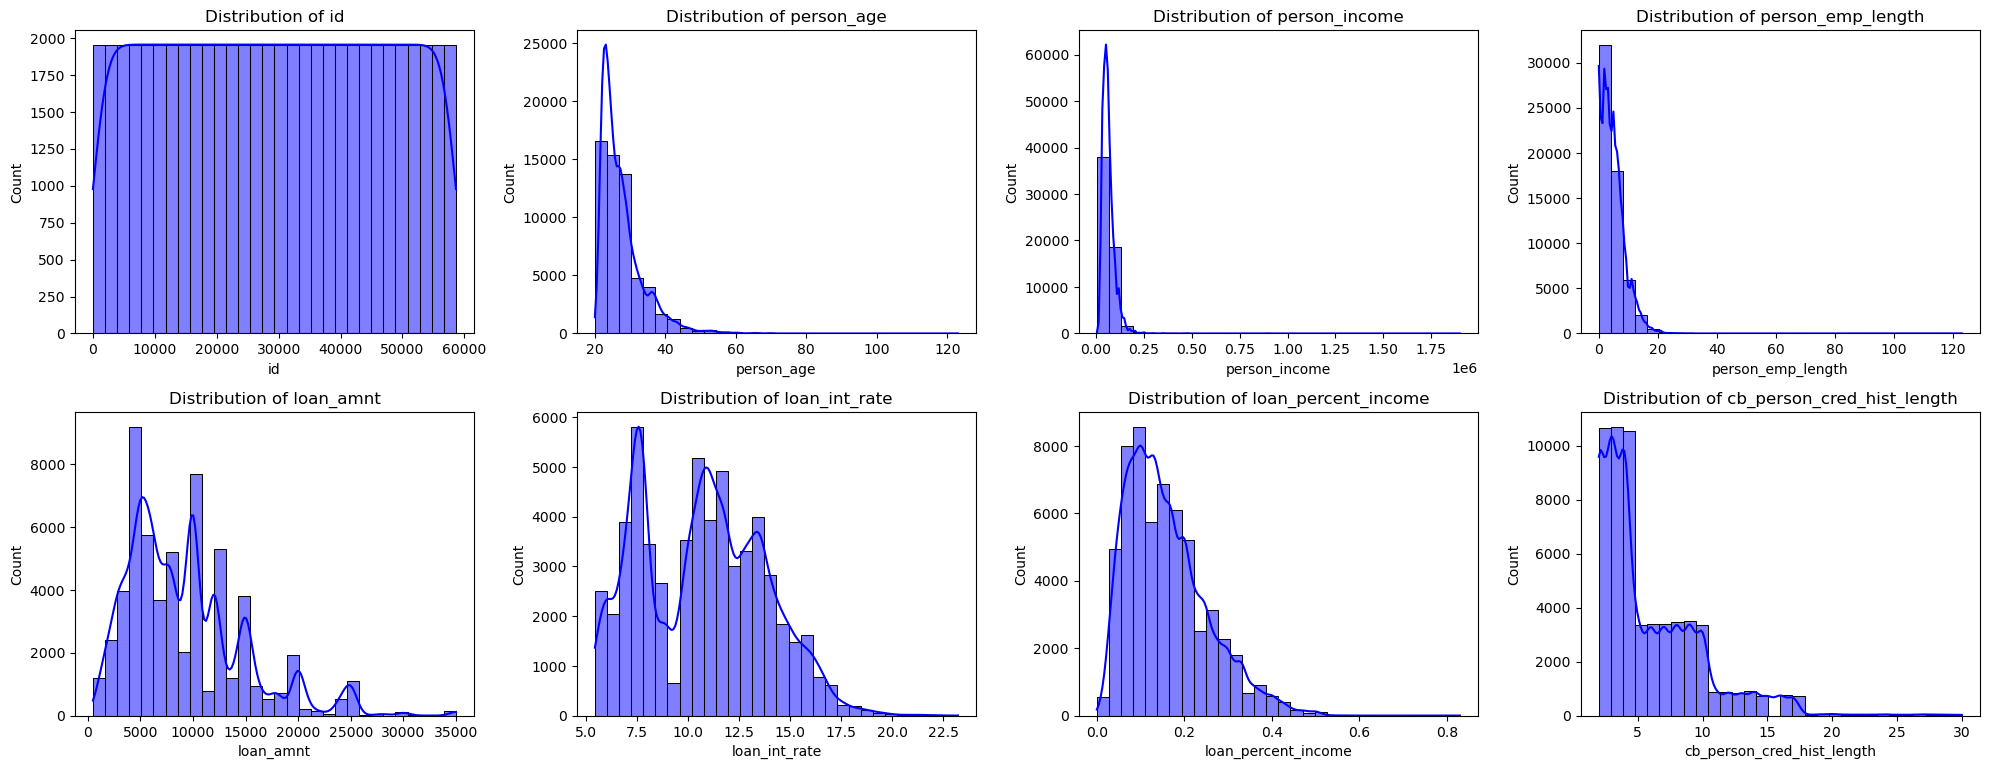

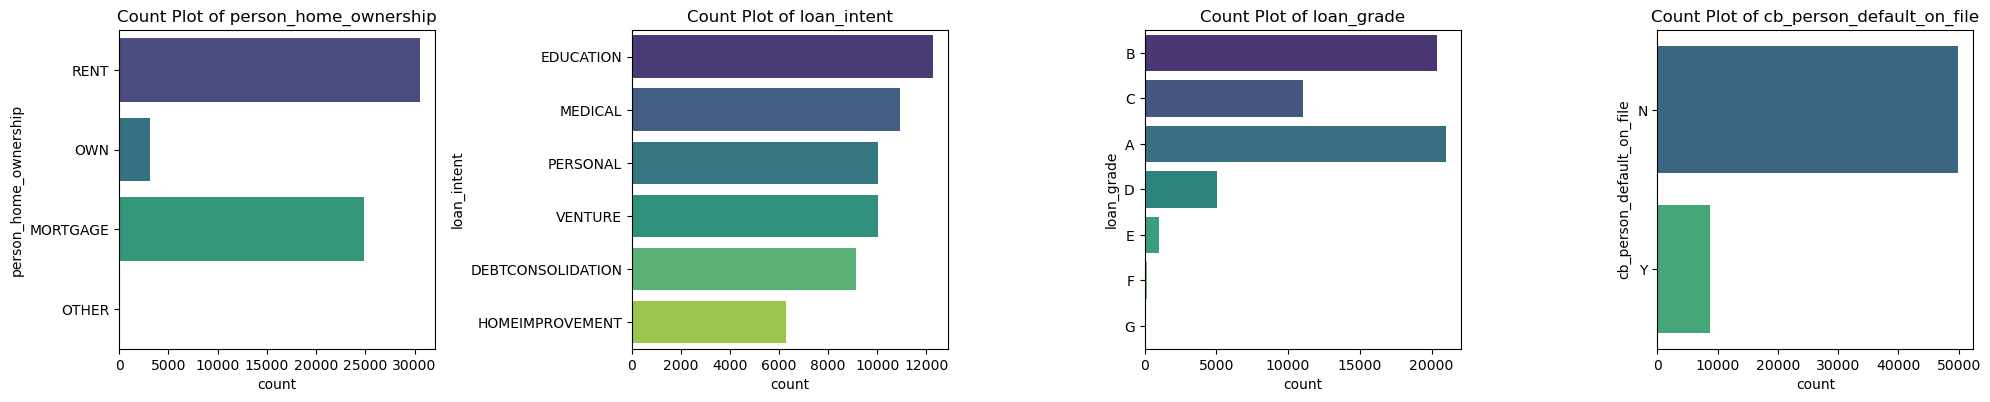

In [6]:
# Numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('loan_status')  # Exclude target

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(4, 4, i+1)
    sns.histplot(data[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(4, 4, i+1)
    sns.countplot(y=col, data=data, palette='viridis')
    plt.title(f'Count Plot of {col}')
plt.tight_layout()
plt.show()

### Bivariate Analysis

Analyzing relationships between features and the target variable.

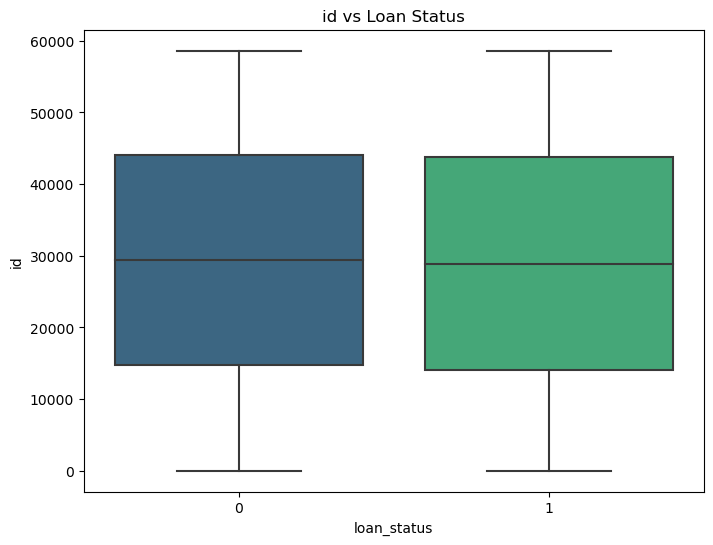

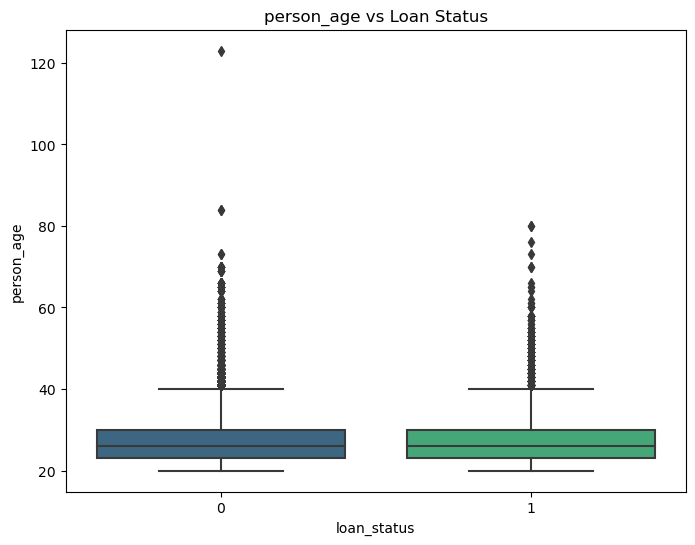

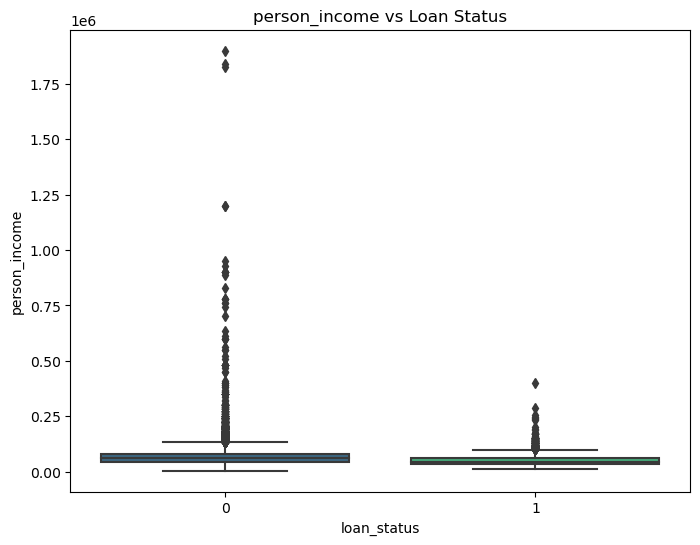

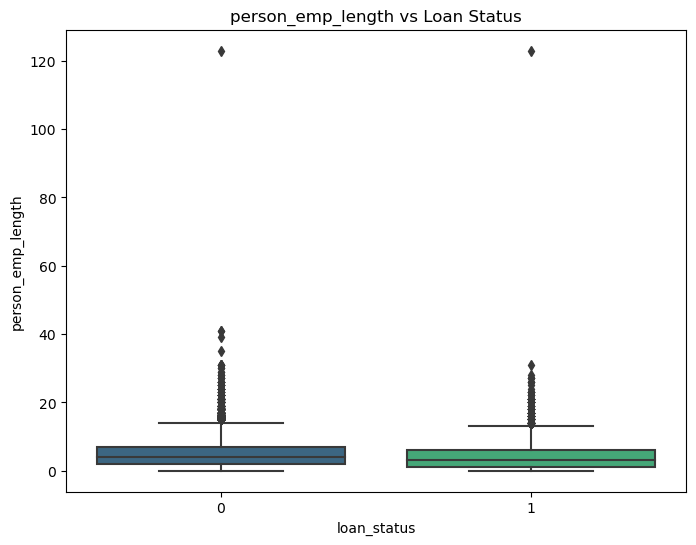

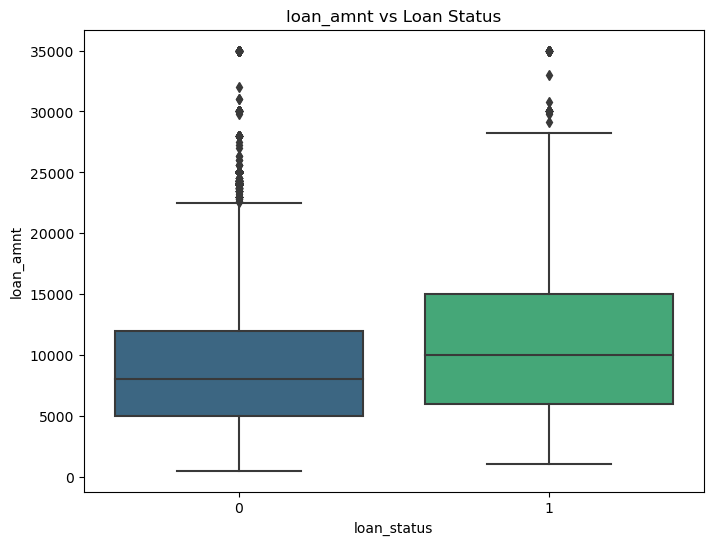

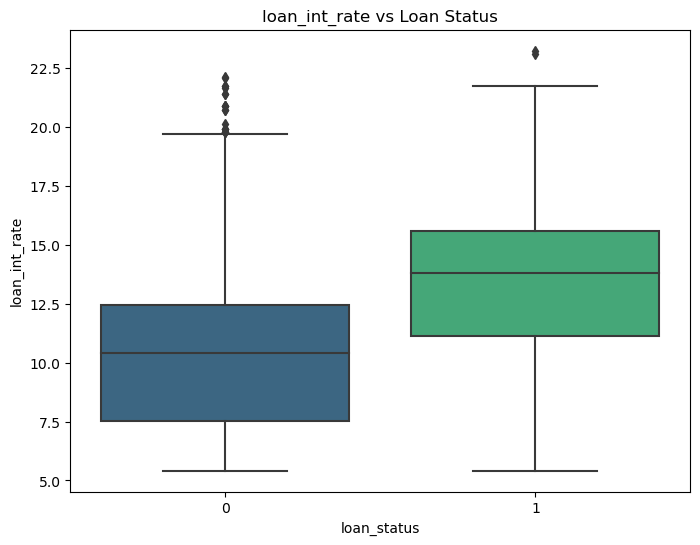

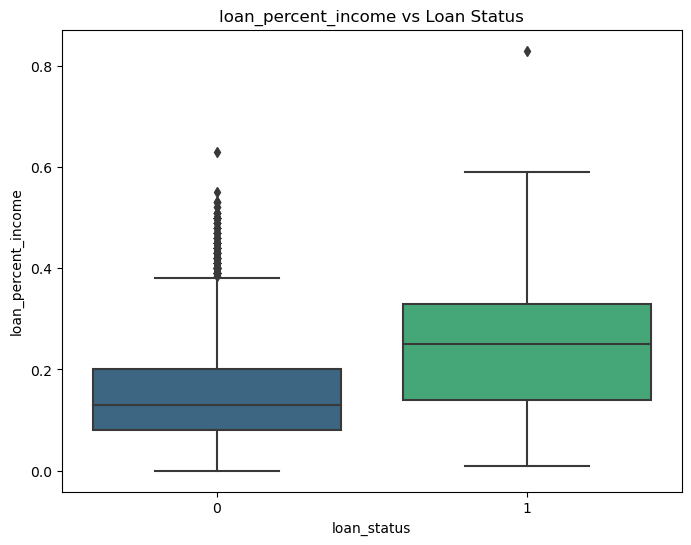

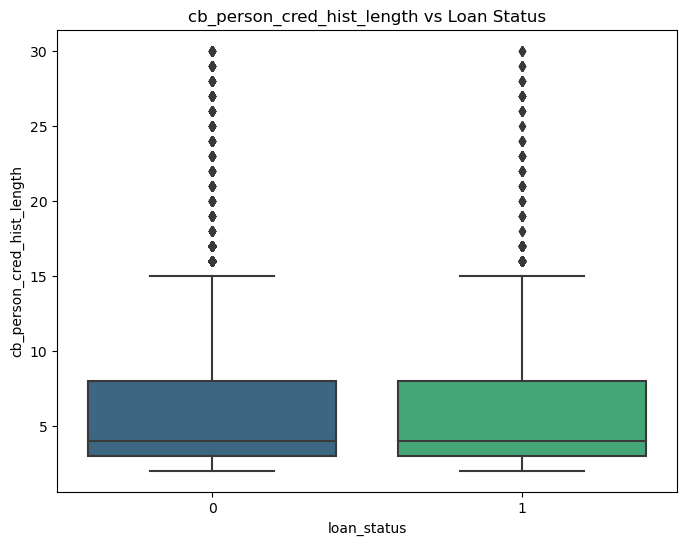

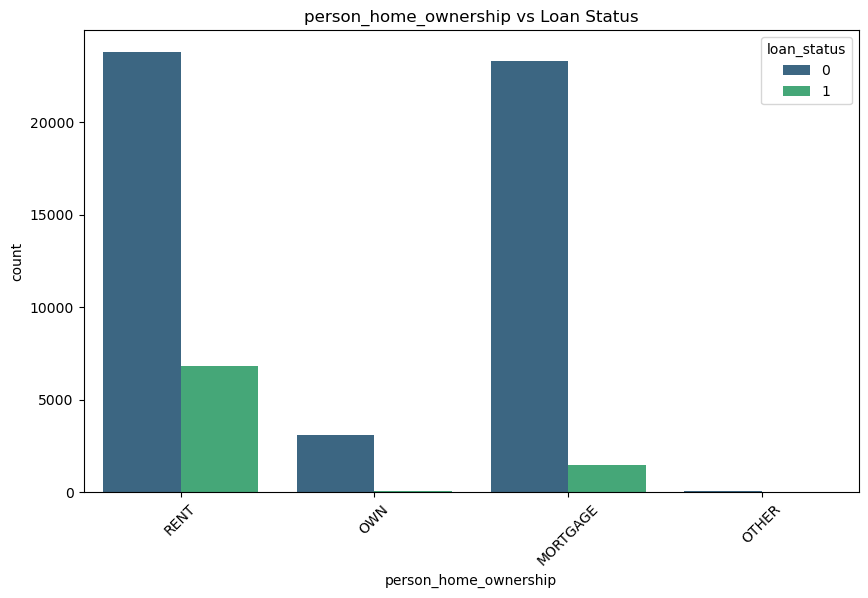

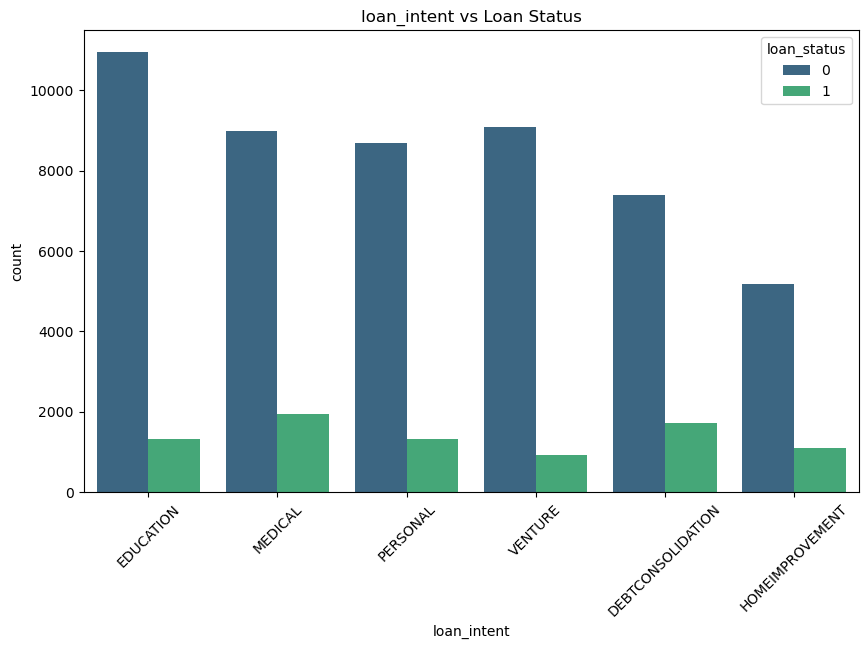

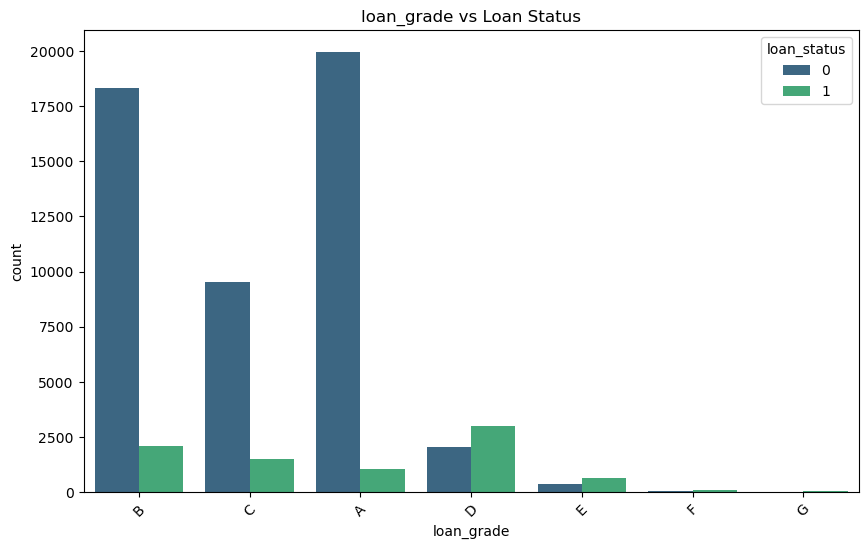

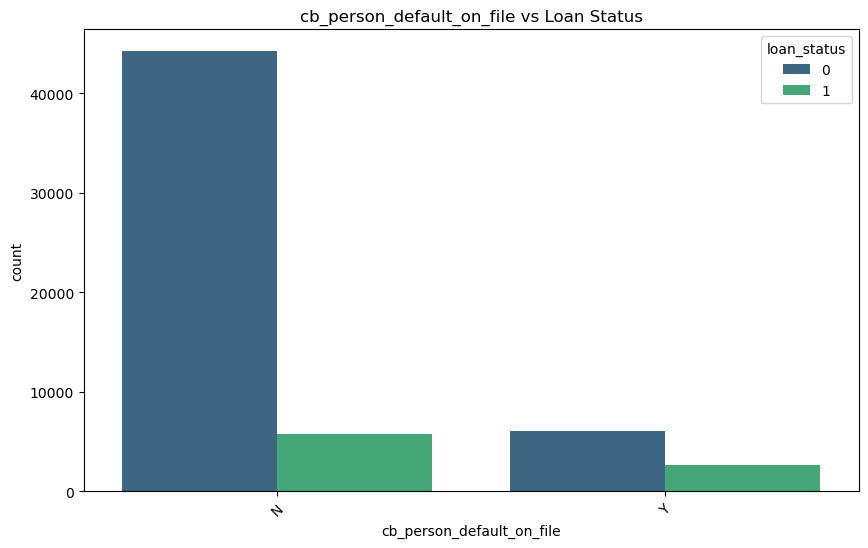

In [7]:
# Numerical features vs target
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='loan_status', y=col, data=data, palette='viridis')
    plt.title(f'{col} vs Loan Status')
    plt.show()

# Categorical features vs target
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='loan_status', data=data, palette='viridis')
    plt.title(f'{col} vs Loan Status')
    plt.xticks(rotation=45)
    plt.show()

## Data Preprocessing

### Handling Missing Values

We'll use `SimpleImputer` to fill missing values. Numerical features will be imputed with the median, and categorical features with the most frequent value.

In [8]:
# Identify missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing Values:\n", missing_values)

Missing Values:
 Series([], dtype: int64)


## Feature Engineering

Creating new features or transforming existing ones can provide additional insights to the models.

**Example: Creating an `income_to_loan_ratio` feature.**

In [9]:
# Assuming 'person_income' and 'loan_amnt' are present
if 'person_income' in data.columns and 'loan_amnt' in data.columns:
    data['income_to_loan_ratio'] = data['person_income'] / (data['loan_amnt'] + 1)
    test_data['income_to_loan_ratio'] = test_data['person_income'] / (test_data['loan_amnt'] + 1)

### Encoding Categorical Variables

We'll use `OneHotEncoder` for nominal categorical variables.

In [10]:
# Identify categorical and numerical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('loan_status')  # Exclude target

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Creating the Preprocessing Pipeline

We'll integrate handling of missing values, encoding, and scaling into a pipeline for seamless processing.

In [11]:
# Define the complete pipeline without SMOTE for now
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

## Handling Class Imbalance

Loan approval datasets often have imbalanced classes. We'll use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.

In [12]:
# Separate features and target
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Apply the preprocessing
X_processed = pipeline.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

print("Original class distribution:")
print(y.value_counts())
print("\nResampled class distribution:")
print(y_resampled.value_counts())

Original class distribution:
0    50295
1     8350
Name: loan_status, dtype: int64

Resampled class distribution:
0    50295
1    50295
Name: loan_status, dtype: int64


## Model Training and Evaluation

We'll train multiple models and evaluate their performance.

### Splitting Data

We'll use a simple train-validation split for quick testing.

In [13]:
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42,
    stratify=y_resampled
)

### Gradient Boosting Classifier

In [14]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_valid)

print("Gradient Boosting Validation Accuracy: ", accuracy_score(y_valid, y_pred_gb))
print("Classification Report:\n", classification_report(y_valid, y_pred_gb))

Gradient Boosting Validation Accuracy:  0.9314047121980316
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     10059
           1       0.96      0.90      0.93     10059

    accuracy                           0.93     20118
   macro avg       0.93      0.93      0.93     20118
weighted avg       0.93      0.93      0.93     20118



### XGBoost Classifier

In [15]:
xgb = XGBClassifier(
    random_state=42, eval_metric='logloss', use_label_encoder=False
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)

print("XGBoost Validation Accuracy: ", accuracy_score(y_valid, y_pred_xgb))
print("Classification Report:\n", classification_report(y_valid, y_pred_xgb))

XGBoost Validation Accuracy:  0.9707724425887265
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.99      0.95      0.97     10059

    accuracy                           0.97     20118
   macro avg       0.97      0.97      0.97     20118
weighted avg       0.97      0.97      0.97     20118



### CatBoost Classifier

In [16]:
cat = CatBoostClassifier(random_state=42, verbose=0)

cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_valid)

print("CatBoost Validation Accuracy: ", accuracy_score(y_valid, y_pred_cat))
print("Classification Report:\n", classification_report(y_valid, y_pred_cat))

CatBoost Validation Accuracy:  0.9705239089372701
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.99      0.95      0.97     10059

    accuracy                           0.97     20118
   macro avg       0.97      0.97      0.97     20118
weighted avg       0.97      0.97      0.97     20118



### LightGBM Classifier

In [17]:
lgb = LGBMClassifier(random_state=42)

lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_valid)

print("LightGBM Validation Accuracy: ", accuracy_score(y_valid, y_pred_lgb))
print("Classification Report:\n", classification_report(y_valid, y_pred_lgb))

LightGBM Validation Accuracy:  0.9674420916592107
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.99      0.95      0.97     10059

    accuracy                           0.97     20118
   macro avg       0.97      0.97      0.97     20118
weighted avg       0.97      0.97      0.97     20118



### Ensemble Voting Classifier

Combining multiple models to leverage their strengths.

In [18]:
# Define individual models
model1 = GradientBoostingClassifier(random_state=42)
model2 = XGBClassifier(
    random_state=42, eval_metric='logloss', use_label_encoder=False
)
model3 = CatBoostClassifier(random_state=42, verbose=0)
model4 = LGBMClassifier(random_state=42)

# Create a Voting Classifier
ensemble = VotingClassifier(
    estimators=[
        ('gb', model1),
        ('xgb', model2),
        ('cat', model3),
        ('lgb', model4)
    ],
    voting='soft'
)

# Train the ensemble
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_valid)

print("Ensemble Validation Accuracy: ", accuracy_score(y_valid, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_valid, y_pred_ensemble))

Ensemble Validation Accuracy:  0.9696788945223184
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     10059
           1       0.99      0.95      0.97     10059

    accuracy                           0.97     20118
   macro avg       0.97      0.97      0.97     20118
weighted avg       0.97      0.97      0.97     20118



## Hyperparameter Tuning

Optimizing model parameters using `RandomizedSearchCV` for the best performance.

### Example: Hyperparameter Tuning for XGBoost

In [19]:
from sklearn.model_selection import RandomizedSearchCV

# Reduce the parameter grid size
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42, eval_metric='logloss', use_label_encoder=False
    ),
    param_distributions=param_grid_xgb,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Optionally, use a smaller subset for quick testing
# Uncomment the following lines to use a subset
# X_train_small = X_train[:10000]
# y_train_small = y_train[:10000]

# Fit RandomizedSearchCV
random_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best ROC-AUC Score for XGBoost:", random_search_xgb.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best ROC-AUC Score for XGBoost: 0.9925364744073194


*Repeat similar hyperparameter tuning for other models as needed.*

## Feature Importance

Understanding which features contribute most to the model's predictions.

### Feature Importance from XGBoost

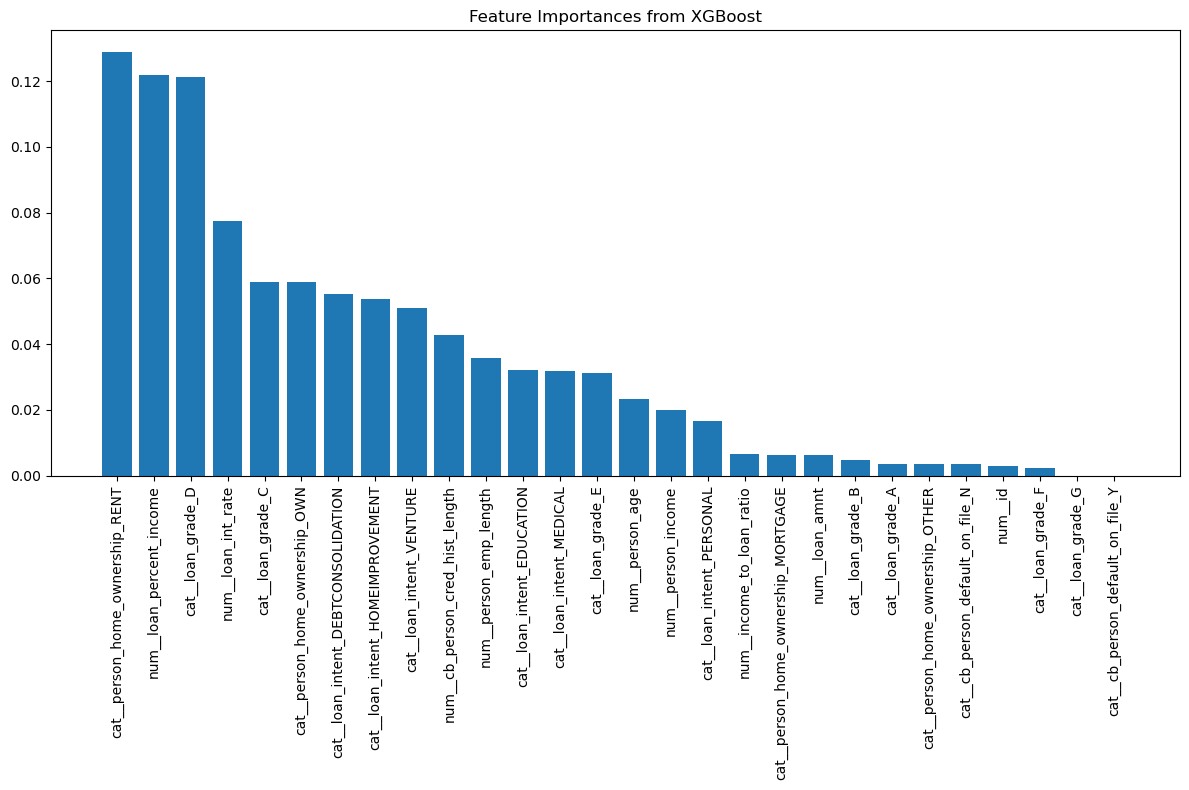

In [20]:
importances = random_search_xgb.best_estimator_.feature_importances_
features = preprocessor.get_feature_names_out()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances from XGBoost")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

### Feature Importance from CatBoost

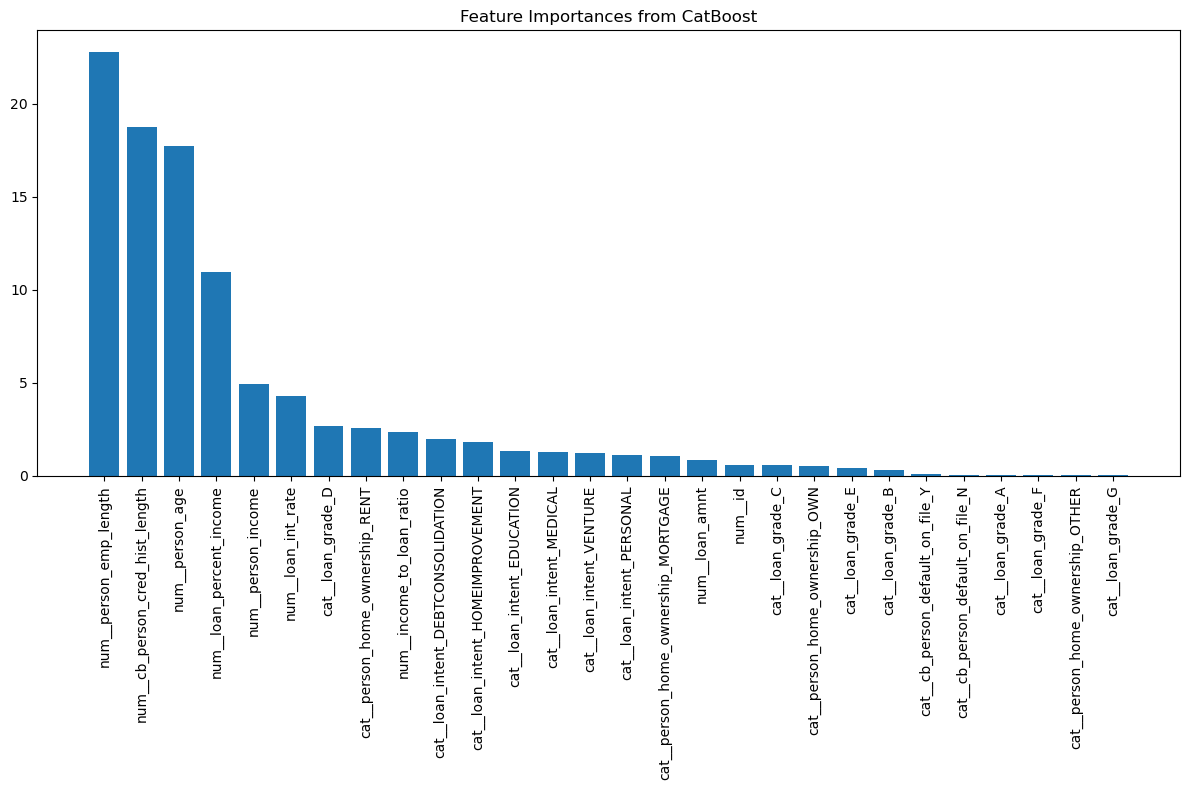

In [21]:
importances_cat = cat.feature_importances_
features_cat = preprocessor.get_feature_names_out()
indices_cat = np.argsort(importances_cat)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances from CatBoost")
plt.bar(range(len(importances_cat)), importances_cat[indices_cat], align='center')
plt.xticks(range(len(importances_cat)), features_cat[indices_cat], rotation=90)
plt.tight_layout()
plt.show()

## Model Explainability

Utilizing SHAP to interpret model predictions and gain deeper insights.

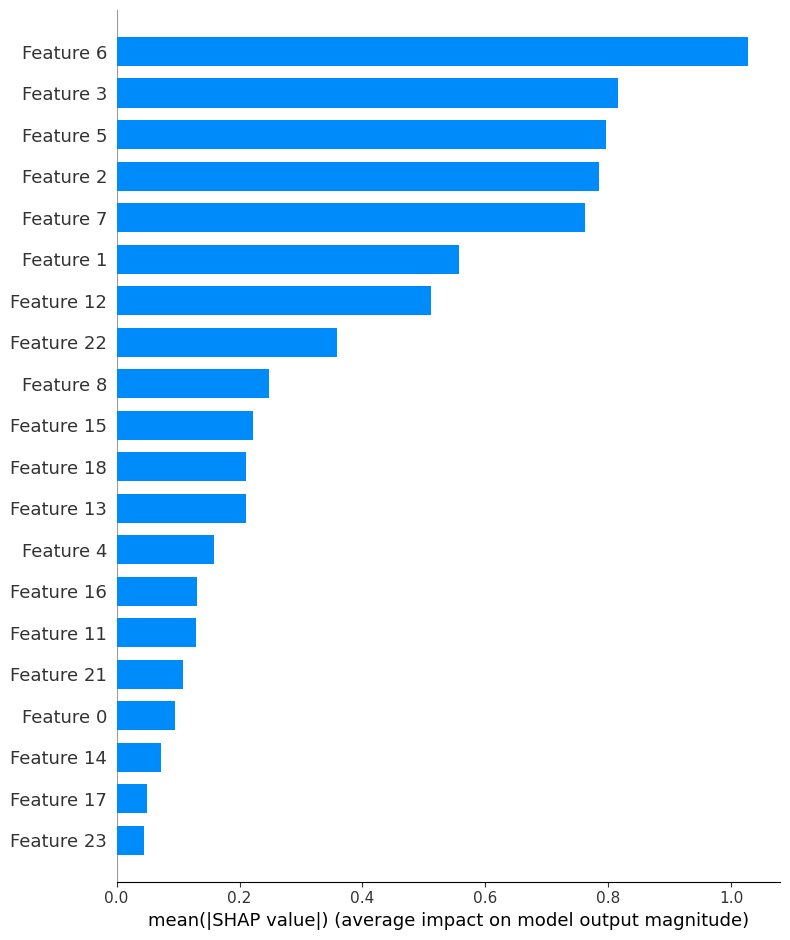

In [22]:
# Initialize SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(random_search_xgb.best_estimator_)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Predictions on Test Data

Using the best-performing model to make predictions on the test dataset.

In [23]:
# Preprocess the test data
X_test = test_data.copy()

# Apply the same feature engineering
if 'person_income' in X_test.columns and 'loan_amnt' in X_test.columns:
    X_test['income_to_loan_ratio'] = X_test['person_income'] / (X_test['loan_amnt'] + 1)

# Apply the same preprocessing pipeline
X_test_processed = pipeline.transform(X_test)

# Predict using the ensemble model
predictions = ensemble.predict(X_test_processed)

print("Predictions on Test Data:")
print(predictions)

Predictions on Test Data:
[1 0 1 ... 0 0 1]


## Submission

Finally, we prepare the submission file with the predictions to be submitted to the competition.

In [24]:
submission['loan_status'] = predictions
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


## Additional Improvements

**Note:** Due to the reduced computation time focus, some advanced steps like cross-validation and extensive hyperparameter tuning have been simplified.